这一章的代码比较逆天，具体看注释。

Training for 100 epochs...
in 2s] Epoch 1 [2560/13374] loss=0.00880123688839376
in 4s] Epoch 1 [5120/13374] loss=0.007671719812788069
in 6s] Epoch 1 [7680/13374] loss=0.007059914680818717
in 8s] Epoch 1 [10240/13374] loss=0.006611915945541114
in 11s] Epoch 1 [12800/13374] loss=0.006199482078664005
evaluating trained model ...
Test set: Accuracy 4404/6700 65.73%
in 14s] Epoch 2 [2560/13374] loss=0.004212932661175728
in 17s] Epoch 2 [5120/13374] loss=0.0041206718306057155
in 19s] Epoch 2 [7680/13374] loss=0.004030837615331014
in 21s] Epoch 2 [10240/13374] loss=0.003940029616933316
in 23s] Epoch 2 [12800/13374] loss=0.0038458853447809814
evaluating trained model ...
Test set: Accuracy 4946/6700 73.82%
in 27s] Epoch 3 [2560/13374] loss=0.003235860029235482
in 29s] Epoch 3 [5120/13374] loss=0.0030549810151569547
in 32s] Epoch 3 [7680/13374] loss=0.0030818649490053454
in 34s] Epoch 3 [10240/13374] loss=0.0030392331187613308
in 36s] Epoch 3 [12800/13374] loss=0.003027400164864957
evaluating t

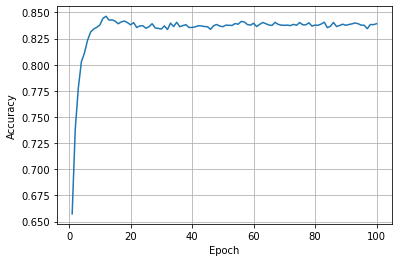

In [6]:
import csv
import time
import matplotlib.pyplot as plt
import numpy as np
import math
import gzip  # 用于读取压缩文件
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence

# 一些超参数
HIDDEN_SIZE = 100
BATCH_SIZE = 256  # 一次训练的样本数，为256个名字
N_LAYER = 2  # RNN的层数
N_EPOCHS = 100
N_CHARS = 128  # ASCII码一共有128个字符
USE_GPU = False


# 构造数据集
class NameDataset(Dataset):
    def __init__(self, is_train_set=True):
        filename = '../Data/names_train.csv.gz' if is_train_set else '../Data/names_test.csv.gz'
        with gzip.open(filename, 'rt') as f:  # rt表示以只读模式打开文件，并将文件内容解析为文本形式
            reader = csv.reader(f)
            rows = list(reader)  # rows是一个列表，每个元素是一个名字和国家名组成的列表
        self.names = [row[0] for row in rows]  # 一个很长的列表，每个元素是一个名字，字符串，长度不一，需要转化为数字
        self.len = len(self.names)  # 训练集：13374  测试集：6700
        self.countries = [row[1] for row in rows]  # 一个很长的列表，每个元素是一个国家名，字符串，需要编码成数字
        # 下面两行的作用其实就是把国家名编码成数字，因为后面要用到交叉熵损失函数
        self.country_list = list(sorted(set(self.countries)))  # 列表，按字母表顺序排序，去重后有18个国家名
        self.country_dict = self.getCountryDict()  # 字典，key是国家名，value是country_list的国家名对应的索引(0-17)
        self.country_num = len(self.country_list)  # 18

    # 根据样本的索引返回姓名和国家名对应的索引，可以理解为(特征,标签)，但这里的特征是姓名，后面还需要转化为数字，标签是国家名对应的索引
    def __getitem__(self, index):
        return self.names[index], self.country_dict[self.countries[index]]

    # 返回样本数量
    def __len__(self):
        return self.len

    # 返回一个key为国家名和value为索引的字典
    def getCountryDict(self):
        country_dict = dict()  # 空字典
        for idx, country_name in enumerate(self.country_list):
            country_dict[country_name] = idx
        return country_dict

    # 根据索引(标签值)返回对应的国家名
    def idx2country(self, index):
        return self.country_list[index]

    # 返回国家名(标签类别)的个数，18
    def getCountriesNum(self):
        return self.country_num


# 实例化数据集
trainset = NameDataset(is_train_set=True)
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
testset = NameDataset(is_train_set=False)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

N_COUNTRY = trainset.getCountriesNum()  # 18个国家名，即18个类别


# 设计神经网络模型
class RNNClassifier(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1, bidirectional=True):
        super(RNNClassifier, self).__init__()
        self.hidden_size = hidden_size  # 隐含层的大小，100
        self.n_layers = n_layers  # RNN的层数，2
        self.n_directions = 2 if bidirectional else 1  # 是否使用双向RNN

        # 词嵌入层：input_size是输入的特征数(即不同词语的个数)，即128;embedding_size是词嵌入的维度(即将词语映射到的向量的维度)，这里让它等于了隐含层的大小，即100
        self.embedding = torch.nn.Embedding(input_size, hidden_size)
        # GRU层：input_size是输入的特征数(这里是embedding_size,其大小等于hidden_size)，即100;hidden_size是隐含层的大小，即100;n_layers是RNN的层数，2;bidirectional是是否使用双向RNN
        self.gru = torch.nn.GRU(hidden_size, hidden_size, n_layers, bidirectional=bidirectional)
        # 全连接层：hidden_size是隐含层的大小，即100;output_size是输出的特征数(即不同类别的个数)，即18
        self.fc = torch.nn.Linear(hidden_size * self.n_directions, output_size)

    def _init_hidden(self, batch_size):
        # 初始化隐含层，形状为(n_layers * num_directions, batch_size, hidden_size)
        hidden = torch.zeros(self.n_layers * self.n_directions, batch_size, self.hidden_size)
        return create_tensor(hidden)

    def forward(self, input, seq_lengths):
        # input shape:B X S -> S X B
        input = input.t()  # 转置，变成(seq_len,batch_size)
        batch_size = input.size(1)  # 256，一次训练的样本数，为256个名字，即batch_size
        hidden = self._init_hidden(batch_size)
        # 1、嵌入层处理，input:(seq_len,batch_size) -> embedding:(seq_len,batch_size,embedding_size)
        embedding = self.embedding(input)

        # pack them up
        gru_input = pack_padded_sequence(embedding, seq_lengths)

        # output:(*, hidden_size * num_directions)，*表示输入的形状(seq_len,batch_size)
        # hidden:(num_layers * num_directions, batch, hidden_size)
        output, hidden = self.gru(gru_input, hidden)
        if self.n_directions == 2:
            hidden_cat = torch.cat([hidden[-1], hidden[-2]],
                                   dim=1)  # hidden[-1]的形状是(1,256,100)，hidden[-2]的形状是(1,256,100)，拼接后的形状是(1,256,200)
        else:
            hidden_cat = hidden[-1]  # (1,256,100)
        fc_output = self.fc(hidden_cat)  # 返回的是(1,256,18)
        return fc_output


# 下面该函数属于数据准备阶段的延续部分，因为神经网络只能处理数字，不能处理字符串，所以还需要把姓名转换成数字
def make_tensors(names, countries):
    # 传入的names是一个列表，每个元素是一个姓名字符串，countries也是一个列表，每个元素是一个整数
    sequences_and_lengths = [name2list(name) for name in
                             names]  # 返回的是一个列表，每个元素是一个元组，元组的第一个元素是姓名字符串转换成的数字列表，第二个元素是姓名字符串的长度
    name_sequences = [sl[0] for sl in sequences_and_lengths]  # 返回的是一个列表，每个元素是姓名字符串转换成的数字列表
    seq_lengths = torch.LongTensor([sl[1] for sl in sequences_and_lengths])  # 返回的是一个列表，每个元素是姓名字符串的长度
    countries = countries.long()  # PyTorch 中，张量的默认数据类型是浮点型 (float)，这里转换成整型，可以避免浮点数比较时的精度误差，从而提高模型的训练效果

    # make tensor of name, (Batch_size,Seq_len) 实现填充0的功能
    seq_tensor = torch.zeros(len(name_sequences), seq_lengths.max()).long()
    for idx, (seq, seq_len) in enumerate(zip(name_sequences, seq_lengths)):
        seq_tensor[idx, :seq_len] = torch.LongTensor(seq)

    # sort by length to use pack_padded_sequence
    # perm_idx是排序后的数据在原数据中的索引,seq_tensor是排序后的数据,seq_lengths是排序后的数据的长度,countries是排序后的国家
    seq_lengths, perm_idx = seq_lengths.sort(dim=0, descending=True)
    seq_tensor = seq_tensor[perm_idx]
    countries = countries[perm_idx]

    return create_tensor(seq_tensor), create_tensor(seq_lengths), create_tensor(countries)


# 把名字转换成ASCII码，返回ASCII码值列表和名字的长度
def name2list(name):
    arr = [ord(c) for c in name]
    return arr, len(arr)


# 是否把数据放到GPU上
def create_tensor(tensor):
    if USE_GPU:
        device = torch.device('cuda:0')
        tensor = tensor.to(device)
    return tensor


# 训练模型
def trainModel():
    total_loss = 0
    for i, (names, countries) in enumerate(trainloader, 1):
        inputs, seq_lengths, target = make_tensors(names, countries)
        output = classifier(inputs, seq_lengths)
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        if i % 10 == 0:
            print(f'[{timeSince(start)}] Epoch {epoch} ', end='')  # end=''表示不换行
            print(f'[{i * len(inputs)}/{len(trainset)}] ', end='')
            print(f'loss={total_loss / (i * len(inputs))}')  # 打印每个样本的平均损失

    return total_loss  # 返回的是所有样本的损失，我们并没有用上它


# 测试模型
def testModel():
    correct = 0
    total = len(testset)
    print('evaluating trained model ...')
    with torch.no_grad():
        for i, (names, countries) in enumerate(testloader, 1):
            inputs, seq_lengths, target = make_tensors(names, countries)
            output = classifier(inputs, seq_lengths)
            pred = output.max(dim=1, keepdim=True)[1]  # 返回每一行中最大值的那个元素的索引，且keepdim=True，表示保持输出的二维特性
            correct += pred.eq(target.view_as(pred)).sum().item()  # 计算正确的个数
        percent = '%.2f' % (100 * correct / total)
        print(f'Test set: Accuracy {correct}/{total} {percent}%')

    return correct / total  # 返回的是准确率，0.几几的格式，用来画图


def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)  # math.floor()向下取整
    s -= m * 60
    return '%dmin %ds' % (m, s)  # 多少分钟多少秒


if __name__ == '__main__':
    classifier = RNNClassifier(N_CHARS, HIDDEN_SIZE, N_COUNTRY, N_LAYER)
    if USE_GPU:
        device = torch.device('cuda:0')
        classifier.to(device)

    # 定义损失函数和优化器
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = optim.Adam(classifier.parameters(), lr=0.001)

    start = time.time()
    print('Training for %d epochs...' % N_EPOCHS)
    acc_list = []
    # 在每个epoch中，训练完一次就测试一次
    for epoch in range(1, N_EPOCHS + 1):
        # Train cycle
        trainModel()
        acc = testModel()
        acc_list.append(acc)

    # 绘制在测试集上的准确率
    epoch = np.arange(1, len(acc_list) + 1)
    acc_list = np.array(acc_list)
    plt.plot(epoch, acc_list)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid()
    plt.show()


在机器学习中，训练数据和测试数据是两个独立的数据集，用于训练和评估模型的性能。在训练模型时，通常会对训练数据进行随机打乱，以确保每个样本都有机会被用于训练，减少模型对数据的过拟合，提高泛化能力。但是，对于测试数据，我们希望评估模型在未见过的数据上的性能，因此不应该对测试数据进行打乱，以确保模型在真实场景中的性能得到准确评估。

因此，在上述代码中，我们对训练数据集进行shuffle=True的打乱操作，以便每个batch的数据是随机的，有助于模型更好地学习到数据的分布特征；而对于测试数据集，我们设置shuffle=False，以确保测试集中的数据顺序不会影响模型的评估结果，避免测试结果受到无意义的影响。